<a href="https://colab.research.google.com/github/Pilo1961/QuestionAnswer_System/blob/master/code/Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook setup

In [1]:
#load data from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import pickle
from textblob import TextBlob
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Read data

In [0]:
#load train data from pickle
with open("/content/drive/My Drive/QA/df_train.pkl", "rb") as f:
    train_data = pickle.load(f)

train_data.drop(columns=['id','title'],inplace=True)
train_data.dropna(inplace=True)

In [40]:
train_data.head()

,answer_start,text,context,question
0,515,Saint Bernadette Soubirous,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...
1,187,a copper statue of Christ,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?
2,279,the Main Building,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...
3,381,a Marian place of prayer and reflection,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?
4,92,a golden statue of the Virgin Mary,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...


In [0]:
#load embeddings from pickle
#train question embedding
with open("/content/drive/My Drive/QA/train_question.pkl", "rb") as f:
    train_question_emb = pickle.load(f)

#train context embeddings
with open("/content/drive/My Drive/QA/train_dict.pkl", "rb") as f:
    train_context_emb_list = pickle.load(f)

### Format data

Ordenamos los datos en forma de listas anidadas.
* La variable emb es una lista anidada con los embeddings de las oraciones del contexto.
* La variable data contiene las oraciones tokenizadas del contexto
* q_embedding tiene los embeddings de las preguntas.

In [0]:
data=[]
emb=[]
last_context=[]

for context in train_data['context']:

  if context == last_context:
    data.append(temp)
    emb.append(temp_emb)
    continue
  
  temp=[]
  temp_emb=[]
  for sent in sent_tokenize(context):
    s=sent.lower()
    temp.append(s)
    e=c_embedding[s]
    temp_emb.append(e)
  
  data.append(temp)
  emb.append(temp_emb)
  last_context=context
  #print(j)

#train_data['oraciones']=data
#train_data['question_emb']=q_embedding
#train_data['cont_emb']=emb

In [20]:
# Todas las variables tienen la misma longitud que el df original
print(len(train_data_emb))
print(len(data))
print(len(q_embedding))

87636
87636
87636


# Target

Para hacer la variable target buscamos la respuesta literal dentro del contexto. El target es la oración donde aparece la respuesta.

In [23]:
train_data.head()

,answer_start,text,context,question
0,515,Saint Bernadette Soubirous,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...
1,187,a copper statue of Christ,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?
2,279,the Main Building,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...
3,381,a Marian place of prayer and reflection,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?
4,92,a golden statue of the Virgin Mary,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...


In [42]:
#Busca la oracion que tiene la respuesta literal dentro del contexto
#guarda la posicion de la oracion dentro del contexto
# Si no la encuentra deja target = -1
train_data["target"]=-1
for i in range (len(train_data)):
  respuesta=train_data["text"][i].lower()
  for j, sent in enumerate(data[i]):
    if respuesta in sent: 
      train_data["target"][i] = j
      break


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [43]:
#casos que no se encontro la respuesta
sum(train_data["target"]==-1)

981

Encontramos 981 casos que representan el 1.11%  
Dado que se trata de un problema de comprnesión de lectura y un supuesto en el planteamiento es que encontramos la respuesta a la pregunta literal en el contexto, procedemos a quitar esos casos de nuestro analisis.

In [52]:
index=train_data["target"]==-1
train_data=train_data[index]
train_data_emb=train_data_emb[-index.index]
#data=data[index]
#q_embedding=q_embedding[index]

TypeError: ignored

In [53]:
int(index.index)

TypeError: ignored

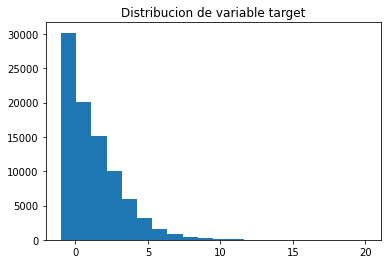

In [33]:
plt.hist(train_data["target"],bins=20)
plt.title("Distribucion de variable target")
plt.show()

In [35]:
print(np.quantile(train_data["target"],.99))
pd.DataFrame(train_data["target"]).describe()

7.0


,target
count,87636.000000
mean,1.615786
std,1.813921
min,-1.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,20.000000


# Prediccion

In [0]:
norma=lambda x:np.sqrt(sum(x*x))
distancia_coseno=lambda x,y: 1-sum(x*y)/(norma(x)*norma(y))
distancia_euclidiana=lambda x,y: norma(x-y)

In [0]:
euc_prediction=[]
cos_prediction=[]
de=[]
dc=[]

for i in range(len(train_data)):
  dc_min=1000
  de_min=1000
  temp_c=[]
  temp_e=[]
  for j, sent_emb in enumerate(train_data_emb[i]):
    dist_euc=distancia_euclidiana(sent_emb,q_embedding[i])
    dist_cos=distancia_coseno(sent_emb,q_embedding[i])  
    temp_c.append(dist_cos)
    temp_e.append(dist_euc)

  euc_prediction.append(np.argmin(temp_e))
  cos_prediction.append(np.argmin(temp_e))
  de.append(temp_e)
  dc.append(temp_c)
  if i%5000==0: print(i)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000


In [0]:
train_data["euclid_prediction"]=euc_prediction
train_data["cosine_prediction"]=cos_prediction

# Acuracy

In [0]:
euclid=0
cosine=0
for i in range(len(train_data)):
  right=train_data["target"][i]
  e=train_data["euclid_prediction"][i]
  c=train_data["cosine_prediction"][i]
  if(right==e):euclid+=1
  if(right==c):cosine+=1  

print("Cosine accuracy",cosine/len(train_data))
print("Euclidian accuracy",euclid/len(train_data))

Cosine accuracy 0.36963120178921904
Euclidian accuracy 0.36963120178921904


In [0]:
i=5906
print(euc_prediction[i])
print(de[i])
print(np.argmin(de[i]))

print("################")
print(cos_prediction[i])
print(dc[i])
print(np.argmin(dc[i]))

0
[4.029263881098831, 4.681837595590444, 4.15731556695472, 5.59215571634795, 4.898281361612705]
0
################
0
[0.598807264096215, 0.5742157597495685, 0.575494689885459, 0.546344420426411, 0.5854704377479172]
3


In [0]:
import pickle
with open("/content/drive/My Drive/distancias_cos.pickle", 'wb') as handle:
    pickle.dump(dc, handle)

In [0]:
import pandas as pd

df=pd.DataFrame(train_data)
df=pd.concat([df,de,dc,train_data_emb,q_embedding])

TypeError: ignored

In [0]:
euc_prediction[0]

1

In [0]:
cos_prediction[0]

2